## 1. Birth Rate vs. Socio-economic Drivers

### Scatter + Trendline

Plot the relationship between Birth Rate (on the y-axis) and each of the following socio-economic indicators (on the x-axis) separately:

* GDP per capita
* Internet Users (%)
* CO₂ per capita

### Faceted Scatter Matrix

 This matrix will display the pairwise relationships between Birth Rate and all the chosen predictor variables (GDP per capita, Internet Users %, CO₂ per capita). This approach provides an instant overview of how these variables co-move with birth rate and with each other.

### Lagged Analysis

To explore potential delayed effects of economic factors on birth rates, compute lagged versions of the socio-economic indicators. For example, analyze the relationship between:

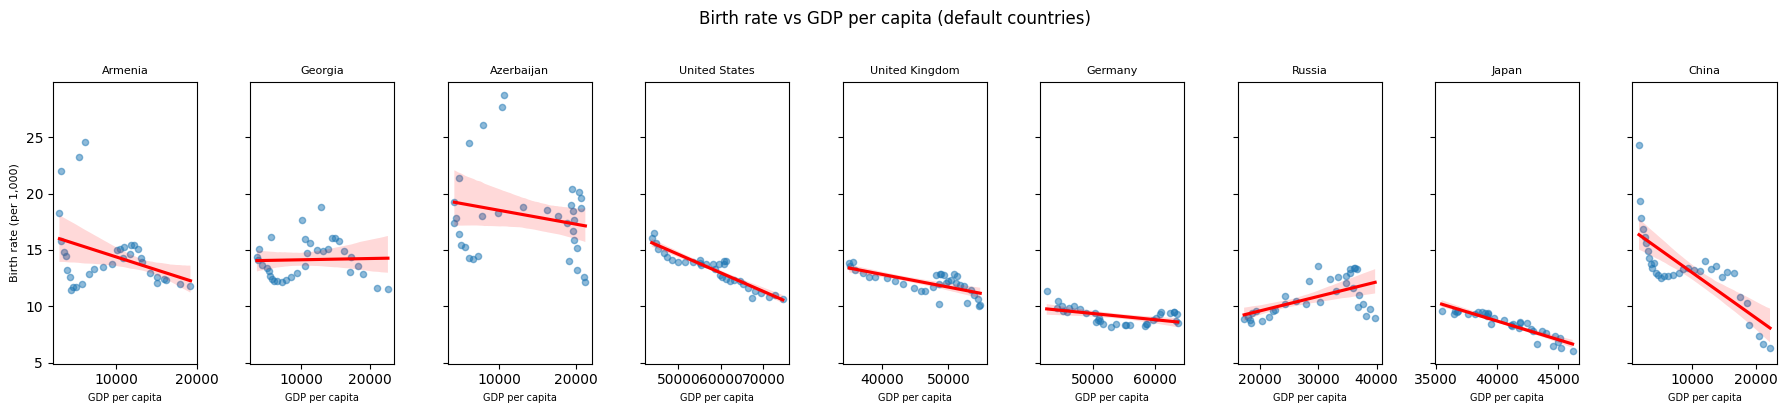

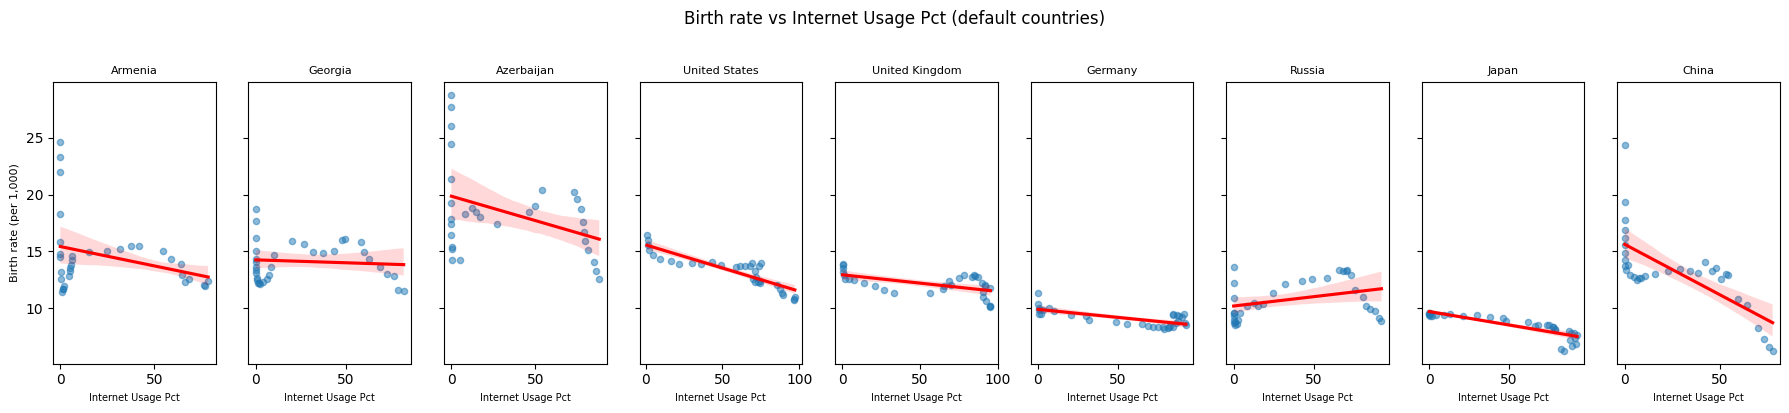

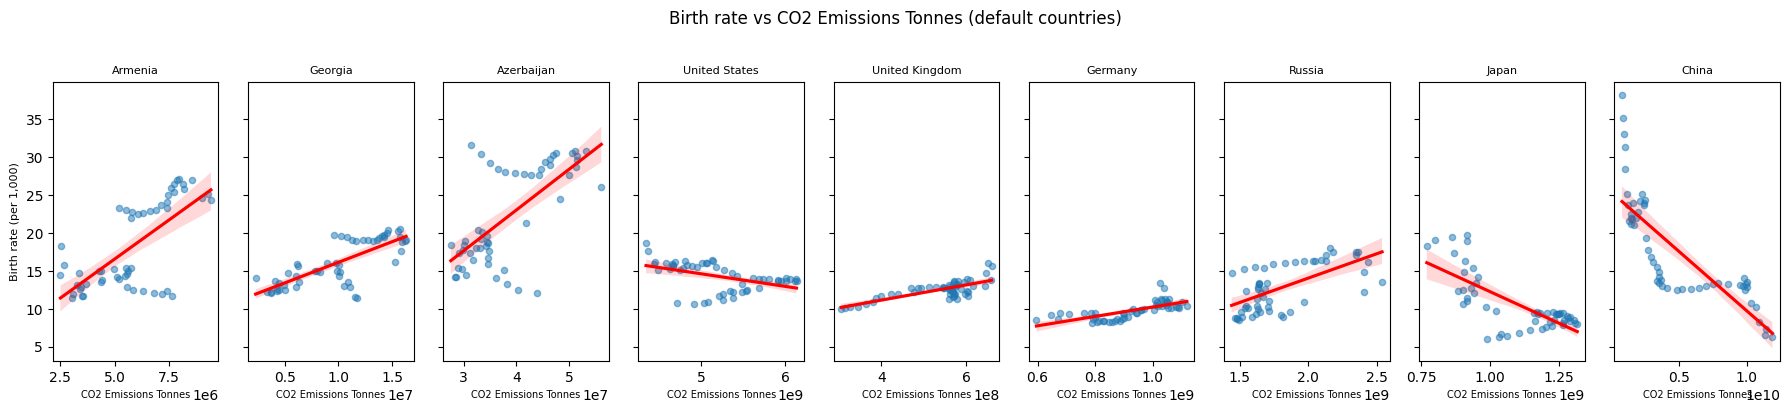

In [14]:
from dash import Dash, dcc, html, Input, Output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import importlib
import constants
import plotly.express as px
import plotly.graph_objects as go

importlib.reload(constants)

default_countries = constants.default_countries

df = pd.read_csv("../data/generated/filtered_dataset.csv")

predictors = ["GDP_per_capita", "Internet_Usage_Pct", "CO2_Emissions_Tonnes"]


for col in predictors:
    # filter to our 10
    df_sub = df[df['Entity'].isin(default_countries)]

    # set up a 1×10 grid of axes
    fig, axes = plt.subplots(
        nrows=1, ncols=len(default_countries),
        figsize=(len(default_countries)*2, 4),
        sharey=True
    )

    # plot each country in its own subplot
    for ax, country in zip(axes, default_countries):
        d = df_sub[df_sub['Entity'] == country]
        sns.regplot(
            x=col,
            y="Birth rate",
            data=d,
            ax=ax,
            scatter_kws={"alpha": 0.5, "s": 20},
            line_kws={"color": "red"}
        )
        ax.set_title(country, fontsize=8)
        ax.set_xlabel(col.replace("_", " "), fontsize=7)
        if ax is axes[0]:
            ax.set_ylabel("Birth rate (per 1,000)", fontsize=8)
        else:
            ax.set_ylabel("")

    plt.suptitle(f"Birth rate vs {col.replace('_',' ')} (default countries)", y=1.02)
    plt.tight_layout()
    plt.show()


In [27]:
all_countries = sorted(df['Entity'].dropna().unique())

app1 = Dash(__name__)
app1.title = "Birth Rate vs Socio-economic Drivers"

app1.layout = html.Div(
    style={
        "display": "flex",
        "flexDirection": "row",
        "backgroundColor": "#ffffff",
        "color": "#000000",
        "fontFamily": "Arial, sans-serif",
        "padding": "20px",
        "height": "auto",
        "width": "calc(100% - 40px)"
    },
    children=[
        # Sidebar with checklist
        html.Div([
            html.H4("Select countries:", style={"marginBottom": "10px"}),
            dcc.Checklist(
                id='country-selector',
                options=[{"label": c, "value": c} for c in all_countries],
                value=default_countries,
                inputStyle={"marginRight": "5px"},
                labelStyle={'display': 'block', 'color': '#000'},
                style={
                    "overflowY": "auto",
                    "height": "calc(100vh - 100px)",
                    "border": "1px solid #ccc",
                    "padding": "10px",
                    "backgroundColor": "#f9f9f9"
                }
            )
        ], style={
            "width": "25%",
            "marginRight": "20px"
        }),

        # Main content: scatter‐matrix
        html.Div([
            dcc.Graph(
                id='matrix-graph',
                style={
                    "height": "100%",
                    "width": "100%"
                }
            )
        ], style={
            "width": "75%",
            "height": "calc(100vh - 100px)",
        })
    ]
)

# 5. Callback to update the scatter‐matrix when countries are (de)selected
@app1.callback(
    Output('matrix-graph', 'figure'),
    Input('country-selector', 'value')
)
def update_matrix(selected_countries):
    # If none selected, return an empty placeholder
    if not selected_countries:
        fig = go.Figure()
        fig.update_layout(
            title="No countries selected",
            xaxis={"visible": False},
            yaxis={"visible": False}
        )
        return fig

    # Filter and drop NA
    subset = df[df.Entity.isin(selected_countries)][["Entity", "Birth rate"] + predictors].dropna()

    # Build scatter‐matrix
    fig = px.scatter_matrix(
        subset,
        dimensions=predictors + ["Birth rate"],
        color="Entity",
        title=f"Birth rate vs Socio-economic Drivers ({len(selected_countries)} countries)",
        height=700,
    )

    # Tidy up fonts & hiding diagonal
    fig.update_traces(diagonal_visible=False)
    fig.update_layout(
        font=dict(size=8),
        margin=dict(l=40, r=40, t=50, b=40),
        legend_title_text="Country"
    )


    return fig

# 6. Run the app
app1.run(debug=False, port=9050)

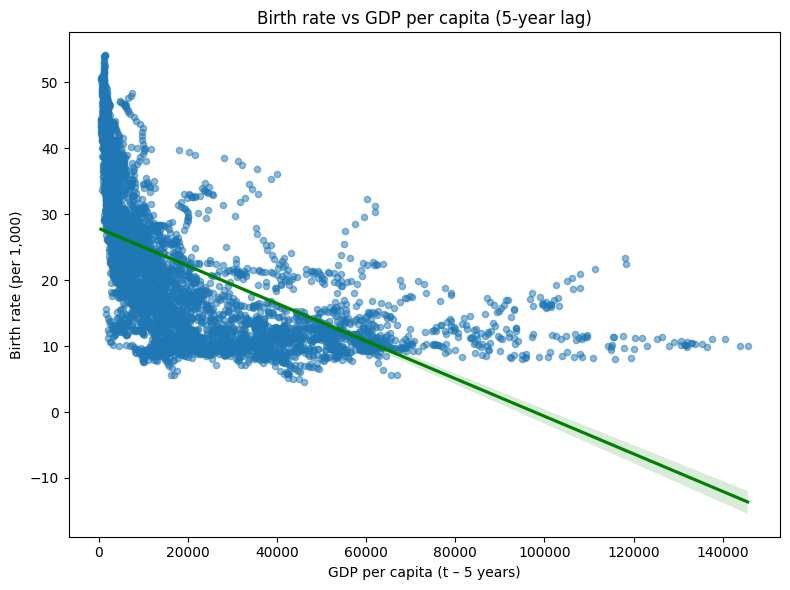

5-year-lagged correlation: -0.58


In [5]:
rows, cols = 2, 5
fig, axes = plt.subplots(
    rows, cols,
    figsize=(cols * 3, rows * 3),
    sharex=True, sharey=True
)

# Flatten axes for easy iteration
axes = axes.flatten()

for ax, country in zip(axes, default_countries):
    df_ct = lag_df[lag_df["Entity"] == country]
    sns.regplot(
        x="GDP_per_capita_lag5",
        y="Birth rate",
        data=df_ct,
        ax=ax,
        scatter_kws={"alpha": 0.5, "s": 20},
        line_kws={"color": "green"}
    )
    ax.set_title(country, fontsize=9)
    ax.set_xlabel("GDP per capita (t–5)", fontsize=8)
    # only label the y-axis on the first subplot
    if ax is axes[0]:
        ax.set_ylabel("Birth rate (per 1,000)", fontsize=8)
    else:
        ax.set_ylabel("")

# Turn off any unused subplots (in case default_countries < rows*cols)
for ax in axes[len(default_countries):]:
    ax.axis("off")

plt.suptitle("Birth rate vs GDP per capita (5-year lag) by Country", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()